In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import math

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import VoxelModelCache
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures
from mcmodels.core.connectivity_data import get_connectivity_data
from mcmodels.models.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique #, unionize
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loss#get_loocv_predictions,get_loss#get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_leaves_ontologicalorder, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3#get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_indices_2ormore

# from mcmodels.core.utils import get_regionalized_normalized_data
# from mcmodels.core.utils import get_connectivity
# from mcmodels.core.utils import get_ontological_order_leaf
# from mcmodels.core.utils import get_nw_loocv,get_wt_inds
# from mcmodels.core.utils import get_countvec
# from mcmodels.core.utils import get_injection_hemisphere_id
# from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
# from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.regressors import NadarayaWatson
from mcmodels.core.plotting import plot_loss_surface,plot_loss_scatter

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation

In [2]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

annotation/ccf_2017


In [3]:
connectivity_data = get_connectivity_data(cache, major_structure_ids, experiments_exclude, remove_injection = False)
connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
connectivity_data.get_centroids()
connectivity_data.get_data_matrices(default_structure_ids)
connectivity_data.get_crelines(data_info)

512
703
1089
1097
315
313
354
698
771
803
477
549


In [4]:
#major division segregation is legacy code but convenient for fast cross validation in major division model
#experiments_minor_structures = get_summarystructure_dictionary(connectivity_data, data_info)
#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(connectivity_data, ontological_order)
#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
sid0 = list(connectivity_data.structure_datas.keys())[0]
eid0 = list(connectivity_data.structure_datas[sid0].experiment_datas.keys())[0]
#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
#contra_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
#ipsi_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)
contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)
#get average intensities of projection structures given ipsi and contra keys
#source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_targetkey, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_targetkey, return_counts=True)

target_order = lambda x: np.array(ontological_order)[np.isin(ontological_order, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])

In [5]:
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
connectivity_data.ai_map = ai_map
connectivity_data.get_summarystructures(data_info)
connectivity_data.leafs = leafs
connectivity_data.get_regionalized_normalized_data(ontological_order, ipsi_targetkey, contra_targetkey)
connectivity_data.get_creleaf_combos()
connectivity_data.leaf2_index_matrices = get_indices_2ormore(connectivity_data.leafs)
connectivity_data.creleaf2_index_matrices = get_indices_2ormore(connectivity_data.creleaf_combos)

In [ ]:

def get_nw_predictions(projections, dists, gamma):
  
     
    projections = np.asarray(projections, dtype=np.float32)
    neval = dists.shape[1]
    #nexp = centroids.shape[0]
    predictions = np.zeros((neval, projections.shape[1]))
    predictions[:] = np.nan
    
    #print(model_index_val.shape, eval_index_val.shape)
    #weights = np.exp(- dists / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
    for i in range(neval):
        dists_i = dists[:,i] - np.min(dists[:,i])
        #dists_i = dists[i,:] - np.min(dists[i,:])
        weights_i = np.exp(- dists_i * gamma)
        weights_i = np.asarray(weights_i, dtype=np.float32)
        weights_i[np.isnan(weights_i)] = 0.
        weights_i = weights_i / np.sum(weights_i)
        predictions[i] = np.dot(weights_i, projections)
        
    return(predictions) 

def get_connectivity_matrices2_nw(connectivity_data, gamma_dict, cres, structures, model_ordering, source_ordering, target_ordering, eval_cres, cre_model = True):
    
    nsource = len(source_ordering)
    #n#target = len(target_ordering)
    ncre = len(eval_cres)

    ipsi_target_regions = connectivity_data.ipsi_target_regions
    contra_target_regions = connectivity_data.contra_target_regions                               
    ipsi_indices= np.asarray([])
    contra_indices = np.asarray([])
    for iy in target_ordering: 
        ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
        contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
    ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
    contra_indices = np.asarray(contra_indices, dtype = int)    
    reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
    ntarget = len(reorder)
      
    connectivity = np.zeros((ncre, nsource, ntarget))
    connectivity[:] = np.nan
    #structure_major_dictionary = connectivity_data.structure_major_dictionary
    for c in range(ncre):
        for i in range(nsource):
            print(i,source_ordering[i])
            sid = model_ordering[i,0]#structure_major_dictionary[source_ordering[i]]
            gamma = gamma_dict[sid]
            connectivity[c,i] = get_region_prediction2(cache,
                                                      connectivity_data.structure_datas[sid],
                                                      exp_structures = structures[sid],
                                                      model_region = model_ordering[i,1],
                                                      prediction_region= source_ordering[i],
                                                      cre = eval_cres[c],
                                                      gamma = gamma_dict[sid],
                                                      cre_model = cre_model)
                                                      
    connectivity = connectivity[:,:,reorder]                                                  
                                                      
    return(connectivity)


def get_region_prediction2(cache, structure_data,  exp_structures, model_region, prediction_region, cre, gamma, surface = None, cre_model = False):
    
    model_experiments = np.where(exp_structures == model_region)[0]
    nexp = len(model_experiments)
    
    cres = structure_data.crelines[model_experiments]
    mask = Mask.from_cache(cache,structure_ids=[prediction_region],hemisphere_id=2)

#     if surface != None and cre_model != True:
#         means = get_means(projections,cres, np.repeat(model_region,nexp))
        
#         losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[model_region])
#         predictions = get_nw_predictions(projections, losses, gamma)
#         output = np.mean(predictions, axis = 0)
        
    if surface != None and cre_model == True:
        projections = structure_data.reg_proj_norm[model_experiments]
        centroids = structure_data.centroids[model_experiments]
        means = get_means(projections, cres, np.repeat(model_region,nexp))
        #print(means)
        print(prediction_region, model_region,means.keys())
        #supposed to check if theres a cre in that region
        if np.isin(model_region, list(means.keys())):
            if np.isin(cre, np.asarray(list(means[model_region].keys()))):
                losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[model_region])
                predictions = get_nw_predictions(projections, losses, gamma)
                output = np.mean(predictions, axis = 0)
            else:
                output = np.zeros(projections.shape[1])
                output[:] = np.nan
        else:
            output = np.zeros(projections.shape[1])
            output[:] = np.nan           
#     if surface == None and cre_model != True:
#         means = get_means(projections, cres, [model_region])
#         predictions = means[cres]
#         output = np.mean(predictions, axis = 0)
        
    if surface == None and cre_model == True:
        
        
        modelcre_experiments = np.where(cres == cre)[0]
        if len(modelcre_experiments)>0:
            projections = structure_data.reg_proj_norm[model_experiments][modelcre_experiments]
            centroids = structure_data.centroids[model_experiments][modelcre_experiments]
            #print((pairwise_distances(centroids, mask.coordinates)**2).shape)
            predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(structure_data.reg_proj_norm.shape[1])
            output[:] = np.nan  
            
    if surface == None and cre_model == False:
        
        if len(model_experiments)>0:
            projections = structure_data.reg_proj_norm[model_experiments]
            centroids = structure_data.centroids[model_experiments]
            predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(structure_data.reg_proj_norm.shape[1])
            output[:] = np.nan  
        
    return(output)


#good one
#model_ordering_leafs,model_region_structures are len n exps, which model to use
#model_experiments_leaf,model_experiments_structure are inds of 
def get_connectivity_matrices3(connectivity_data, surfaces, cres, structures_smooth,structures_surface, model_ordering_leafs, model_ordering_surfaces, source_ordering, target_ordering, eval_cres):
    
    nsource = len(source_ordering)
    #n#target = len(target_ordering)
    ncre = len(eval_cres)

    ipsi_target_regions = connectivity_data.ipsi_target_regions
    contra_target_regions = connectivity_data.contra_target_regions                               
    ipsi_indices= np.asarray([])
    contra_indices = np.asarray([])
    for iy in target_ordering: 
        ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
        contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
    ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
    contra_indices = np.asarray(contra_indices, dtype = int)    
    reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
    ntarget = len(reorder)
      
    connectivity = np.zeros((ncre, nsource, ntarget))
    connectivity[:] = np.nan
    #structure_major_dictionary = connectivity_data.structure_major_dictionary
    for c in range(ncre):
        for i in range(nsource):
            print(i,source_ordering[i])
            sid = model_ordering_leafs[i,0]#structure_major_dictionary[source_ordering[i]]
            gamma = surfaces[sid].gamma#gamma_dict[sid]
            connectivity[c,i] = get_region_prediction3(cache,
                                                      connectivity_data.structure_datas[sid],
                                                      #structures_sid = structures[sid],
                                                       structures_surface_sid =structures_surface[sid],
                                                       structures_smooth_sid= structures_smooth[sid],
                                                      model_region_leaf = model_ordering_leafs[i,1],
                                                       model_region_surface = model_ordering_surfaces[i,1],
                                                      prediction_region= source_ordering[i],
                                                      cre = eval_cres[c],
                                                      gamma = surfaces[sid].bestgamma,
                                                      surface = surfaces[sid],
                                                      cre_model = True)
                                                      
    connectivity = connectivity[:,:,reorder]                                                  
                                                      
    return(connectivity)

def get_region_prediction3(cache, structure_data,  structures_surface_sid,structures_smooth_sid, model_region_surface, model_region_leaf, prediction_region, cre, gamma, surface = None, cre_model = False):
    

    model_experiments_leaf = np.where(structures_smooth_sid == model_region_leaf)[0]
    model_experiments_surface = np.where(structures_surface_sid == model_region_surface)[0]
    
    nexp_surface = len(model_experiments_surface)
    
    cres_surface = structure_data.crelines[model_experiments_surface]
    mask = Mask.from_cache(cache,structure_ids=[prediction_region],hemisphere_id=2)
    if surface != None and cre_model == True:
        projections = structure_data.reg_proj_norm[model_experiments_leaf]
        projections_surface = structure_data.reg_proj_norm[model_experiments_surface]
        centroids = structure_data.centroids[model_experiments_leaf]#model_region_leaf
        means = get_means(projections_surface, cres_surface, np.repeat(model_region_surface,nexp_surface))
        #supposed to check if theres a cre in that region
        #if np.isin(model_region_surface, list(means.keys())):
        if centroids.shape[0]>0:
            if np.isin(cre, np.asarray(list(means[model_region_surface].keys()))):
                losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres_surface, cre, means[model_region_surface])
                predictions = get_nw_predictions(projections, losses, gamma)
                output = np.mean(predictions, axis = 0)
            else:
                output = np.zeros(projections.shape[1])
                output[:] = np.nan
        else:
            output = np.zeros(projections.shape[1])
            output[:] = np.nan
    if surface == None and cre_model == True:
        
        
        modelcre_experiments = np.where(cres == cre)[0]
        if len(modelcre_experiments)>0:
            projections = structure_data.reg_proj_norm[model_experiments][modelcre_experiments]
            centroids = structure_data.centroids[model_experiments][modelcre_experiments]
            #print((pairwise_distances(centroids, mask.coordinates)**2).shape)
            predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(structure_data.reg_proj_norm.shape[1])
            output[:] = np.nan  
            
    if surface == None and cre_model == False:
        
        if len(model_experiments)>0:
            projections = structure_data.reg_proj_norm[model_experiments]
            centroids = structure_data.centroids[model_experiments]
            predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(structure_data.reg_proj_norm.shape[1])
            output[:] = np.nan  
       
    return(output)


In [164]:

def get_cre_distances(projections, means_cast, sids, cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        #print(i)
        meani = means_cast[sids[i]][cres[i]]#means_cast.loc[tuple([cres[i], sids[i]])]
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                credist[i,j]  = np.linalg.norm(meani - meanj)#**2
    return(credist)

def get_loss_surface_cv_spline(projections, centroids, cres, sids,fraction):
    means_cast = get_means(projections, cres, sids)
    cre_distances_cv = get_cre_distances_cv(projections, means_cast, sids, cres)
    surface = get_surface_from_distances_spline(projections,centroids,cre_distances_cv, fraction)
    surface.cre_distances_cv = cre_distances_cv
    return(surface)

def get_surface_from_distances_spline(projections,centroids,cre_distances, fraction):
    
    nsamp = centroids.shape[0]
    pairs = np.asarray(np.where(~np.isnan(cre_distances))).transpose() #not all cres will have distances, e.g. if not in same leaf
    ngp = pairs.shape[0]
    
    coordinates = np.zeros((ngp,2))
    projection_distances = np.zeros((ngp,1))
    for i in range(ngp):
        coordinates[i,0] = np.linalg.norm(centroids[pairs[i][0]] - centroids[pairs[i][1]])**2
        coordinates[i,1] = cre_distances[pairs[i][0]][pairs[i][1]]
        projection_distances[i] = np.linalg.norm(projections[pairs[i][0]] - projections[pairs[i][1]])**2
    coordinates_normed = coordinates / np.linalg.norm(coordinates, axis = 0)#**2
    coordinates_normed[np.where(np.isnan(coordinates_normed))] = 0.
    #was n_splines = 10
    surface = LinearGAM(s(0, constraints=['monotonic_inc', 'concave'], n_splines=10) + 
                        s(1, constraints=['monotonic_inc', 'concave'], n_splines=10))

    #surface = NadarayaWatson(kernel='rbf',  gamma  = gamma)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    surface.fit(coordinates_normed[randos], projection_distances[randos])
    surface.coordinates_normed = coordinates_normed
    surface.norms = np.linalg.norm(coordinates, axis = 0)
    surface.projection_distances = projection_distances
    return(surface)

def get_surface_from_distances_nw(projections,centroids,cre_distances, fraction, gamma = 100000):
    
    nsamp = centroids.shape[0]
    pairs = np.asarray(np.where(~np.isnan(cre_distances))).transpose() #not all cres will have distances, e.g. if not in same leaf
    ngp = pairs.shape[0]
    
    coordinates = np.zeros((ngp,2))
    projection_distances = np.zeros((ngp,1))
    for i in range(ngp):
        coordinates[i,0] = np.linalg.norm(centroids[pairs[i][0]] - centroids[pairs[i][1]])**2
        coordinates[i,1] = cre_distances[pairs[i][0]][pairs[i][1]]
        projection_distances[i] = np.linalg.norm(projections[pairs[i][0]] - projections[pairs[i][1]])**2
    coordinates_normed = coordinates / np.linalg.norm(coordinates, axis = 0)#**2
    
    
    
    surface = NadarayaWatson(kernel='rbf',  gamma  = gamma)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    #print(coordinates_normed[randos])
    surface.fit(coordinates_normed[randos], projection_distances[randos])
    surface.coordinates_normed = coordinates_normed
    surface.norms = np.linalg.norm(coordinates, axis = 0)
    surface.projection_distances = projection_distances
    return(surface)

def get_means(projections, cres, sids):
    cre_means = {}
    cre_types = np.unique(cres)
    sid_types = np.unique(sids)
    for i in range(len(sid_types)):
        cre_means[sid_types[i]] = {}
        sid_inds = np.where(sids == sid_types[i])[0]
        for j in range(len(cre_types)): 
            cre_inds = np.where(cres == cre_types[j])[0]
            cre_means[sid_types[i]][cre_types[j]] = np.mean(projections[np.intersect1d(sid_inds, cre_inds)], axis = 0 )
    return(cre_means)

def get_cre_distances(projections, means_cast, sids, cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        #print(i)
        meani = means_cast[sids[i]][cres[i]]#means_cast.loc[tuple([cres[i], sids[i]])]
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                credist[i,j]  = np.linalg.norm(meani - meanj)#**2
    return(credist)

# def get_cre_distances_cv(proj, means_cast, sids,cres):
#     nsamp = cres.shape[0]
#     credist = np.empty((nsamp,nsamp))
#     credist[:] = np.nan
#     for i in range(nsamp):
#         #print(i)
#         meani = means_cast[sids[i]][cres[i]]
#         ls = np.where(sids == sids[i])[0]
#         crs = np.where(cres == cres[i])[0]
#         ncr = len(np.intersect1d(ls, crs))
        
#         meanloocvi = meani
#         if ncr > 1:
#             #meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i]
#             meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ (ncr-1))* proj[i]#results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
#         else:
#             meanloocvi = np.zeros(proj[i].shape[0])
#             meanloocvi[:] = np.nan
            
#         for j in range(nsamp):
#             meanj = means_cast[sids[j]][cres[j]]
#             if sids[j] == sids[i]:
# #                 if cres[i] != cres[j]:

#                 credist[j,i]  = np.linalg.norm(meanloocvi - meanj)
#     nsamp = cres.shape[0]
#     credist = np.empty((nsamp,nsamp))
#     credist[:] = np.nan
#     for i in range(nsamp):
#         #print(i)
#         meani = meani = means_cast[sids[i]][cres[i]]
#         ls = np.where(sids == sids[i])[0]
#         crs = np.where(cres == cres[i])[0]
#         ncr = len(np.intersect1d(ls, crs))
        
#         meanloocvi = meani
#         if ncr > 1:
#             meanloocvi = (meani - (1/ ncr) * proj[i]) * (ncr / (ncr - 1))#(ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
#         else:
#             meanloocvi = np.zeros(proj[i].shape[0])
#             meanloocvi[:] = np.nan
            
#         for j in range(nsamp):
#             meanj = means_cast[sids[j]][cres[j]]
#             if sids[j] == sids[i]:
#                 if cres[i] != cres[j]:
#                     credist[j,i]  = np.linalg.norm(meanloocvi - meanj)
#                     #print('here',i,j,credist[j,i])
#                 else: 
#                     credist[j,i] = 0.
#                     #print('he',i,j,credist[j,i])
                    
    return(credist)

def get_embedding_cv(surface, dists, cre_distances_cv):
    
    ntrain = dists.shape[0]
    norms = surface.norms
    norms[np.where(norms == 0.)] = 1.
    leaf_pairs = np.asarray(np.where(~np.isnan(cre_distances_cv))).transpose()
    nlp = leaf_pairs.shape[0]
    
    losses = np.zeros((ntrain, ntrain))
    for i in range(nlp):
        d_ij = dists[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[0]
        p_ij = cre_distances_cv[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[1]
        losses[leaf_pairs[i][0]][leaf_pairs[i][1]] = surface.predict(np.asarray([[d_ij, p_ij]]))
      
    losses[np.where(losses == 0)] = np.nan
    
    return(losses)


from mcmodels.core import Mask


def get_embedding(surface, dists, cres = None, cre = None, means = None):
    
    ntrain = dists.shape[0]
    neval = dists.shape[1]
    norms = surface.norms
    #cnorm = surface.cnorm
    
    cre_deezy = np.zeros((ntrain))
    
    for i in range(ntrain):
        cre_deezy[i] = np.linalg.norm(means[cres[i]] - means[cre])
    
    losses = np.zeros((ntrain, neval))
    for i in range(ntrain):
        for j in range(neval):
            d_ij = dists[i,j] / norms[0]
            p_i = cre_deezy[i] / norms[1]
            losses[i,j] = surface.predict(np.asarray([[d_ij, p_i]]))
            
    return(losses)



def get_nw_predictions(projections, dists, gamma):
  
     
    projections = np.asarray(projections, dtype=np.float32)
    neval = dists.shape[1]
    #nexp = centroids.shape[0]
    predictions = np.zeros((neval, projections.shape[1]))
    predictions[:] = np.nan
    
    #print(model_index_val.shape, eval_index_val.shape)
    #weights = np.exp(- dists / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
    for i in range(neval):
        dists_i = dists[:,i] - np.min(dists[:,i])
        #dists_i = dists[i,:] - np.min(dists[i,:])
        weights_i = np.exp(- dists_i * gamma)
        weights_i = np.asarray(weights_i, dtype=np.float32)
        weights_i[np.isnan(weights_i)] = 0.
        weights_i = weights_i / np.sum(weights_i)
        predictions[i] = np.dot(weights_i, projections)
        
    return(predictions) 

def get_region_prediction2(cache, structure_data,  exp_structures, model_region, prediction_region, cre, gamma, surface = None, cre_model = False):
    
    model_experiments = np.where(exp_structures == model_region)[0]
    nexp = len(model_experiments)
    
    cres = structure_data.crelines[model_experiments]
    mask = Mask.from_cache(cache,structure_ids=[prediction_region],hemisphere_id=2)

#     if surface != None and cre_model != True:
#         means = get_means(projections,cres, np.repeat(model_region,nexp))
        
#         losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[model_region])
#         predictions = get_nw_predictions(projections, losses, gamma)
#         output = np.mean(predictions, axis = 0)
        
    if surface != None and cre_model == True:
        projections = structure_data.reg_proj_norm[model_experiments]
        centroids = structure_data.centroids[model_experiments]
        means = get_means(projections, cres, np.repeat(model_region,nexp))
        #print(means)
        print(prediction_region, model_region,means.keys())
        #supposed to check if theres a cre in that region
        if np.isin(model_region, list(means.keys())):
            if np.isin(cre, np.asarray(list(means[model_region].keys()))):
                losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[model_region])
                predictions = get_nw_predictions(projections, losses, gamma)
                output = np.mean(predictions, axis = 0)
            else:
                output = np.zeros(projections.shape[1])
                output[:] = np.nan
        else:
            output = np.zeros(projections.shape[1])
            output[:] = np.nan           
#     if surface == None and cre_model != True:
#         means = get_means(projections, cres, [model_region])
#         predictions = means[cres]
#         output = np.mean(predictions, axis = 0)
        
    if surface == None and cre_model == True:
        
        
        modelcre_experiments = np.where(cres == cre)[0]
        if len(modelcre_experiments)>0:
            projections = structure_data.reg_proj_norm[model_experiments][modelcre_experiments]
            centroids = structure_data.centroids[model_experiments][modelcre_experiments]
            #print((pairwise_distances(centroids, mask.coordinates)**2).shape)
            predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(structure_data.reg_proj_norm.shape[1])
            output[:] = np.nan  
            
    if surface == None and cre_model == False:
        
        if len(model_experiments)>0:
            projections = structure_data.reg_proj_norm[model_experiments]
            centroids = structure_data.centroids[model_experiments]
            predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(structure_data.reg_proj_norm.shape[1])
            output[:] = np.nan  
        
    return(output)


In [205]:

def get_loss_surface_cv(projections, centroids, cres, sids,fraction, gamma = 100000):
    means_cast = get_means(projections, cres, sids)
    cre_distances_cv = get_cre_distances_cv(projections, means_cast, sids, cres)
    surface = get_surface_from_distances(projections,centroids,cre_distances_cv, fraction, gamma)
    surface.cre_distances_cv = cre_distances_cv
    return(surface)

def get_surface_from_distances(projections,centroids,cre_distances, fraction, gamma = 100000):
    
    nsamp = centroids.shape[0]
    pairs = np.asarray(np.where(~np.isnan(cre_distances))).transpose() #not all cres will have distances, e.g. if not in same leaf
    ngp = pairs.shape[0]
    
    coordinates = np.zeros((ngp,2))
    projection_distances = np.zeros((ngp,1))
    for i in range(ngp):
        coordinates[i,0] = np.linalg.norm(centroids[pairs[i][0]] - centroids[pairs[i][1]])**2
        coordinates[i,1] = cre_distances[pairs[i][0]][pairs[i][1]]
        projection_distances[i] = np.linalg.norm(projections[pairs[i][0]] - projections[pairs[i][1]])**2
    coordinates_normed = coordinates / np.linalg.norm(coordinates, axis = 0)#**2

    surface = NadarayaWatson(kernel='rbf',  gamma  = gamma)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    surface.fit(coordinates_normed[randos], projection_distances[randos])
    surface.coordinates_normed = coordinates_normed
    surface.norms = np.linalg.norm(coordinates, axis = 0)
    surface.projection_distances = projection_distances
    return(surface)

# def get_cre_distances_cv(proj, means_cast, sids,cres):
#     nsamp = cres.shape[0]
#     credist = np.empty((nsamp,nsamp))
#     credist[:] = np.nan
#     for i in range(nsamp):
#         print(i)
#         meani = meani = means_cast[sids[i]][cres[i]]
#         ls = np.where(leafs[sid] == leafs[sid][i])[0]
#         crs = np.where(cres == cres[i])[0]
#         ncr = len(np.intersect1d(ls, crs))
        
#         meanloocvi = meani
#         if ncr > 1:
#             meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
#         else:
#             meanloocvi = np.zeros(proj[i].shape[0])
#             meanloocvi[:] = np.nan
            
#         for j in range(nsamp):
#             meanj = means_cast[sids[j]][cres[j]]
#             if sids[j] == sids[i]:
#                 credist[i,j]  = np.linalg.norm(meanloocvi - meanj)

#     return(credist)

def get_means(projections, cres, sids):
    cre_means = {}
    cre_types = np.unique(cres)
    sid_types = np.unique(sids)
    for i in range(len(sid_types)):
        cre_means[sid_types[i]] = {}
        sid_inds = np.where(sids == sid_types[i])[0]
        for j in range(len(cre_types)): 
            cre_inds = np.where(cres == cre_types[j])[0]
            cre_means[sid_types[i]][cre_types[j]] = np.mean(projections[np.intersect1d(sid_inds, cre_inds)], axis = 0 )
    return(cre_means)

def get_cre_distances_cv(proj, means_cast, sids,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        #print(i)
        meani = means_cast[sids[i]][cres[i]]
        ls = np.where(sids == sids[i])[0]#np.where(leafs[sid] == leafs[sid][i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        if ncr > 1:
            
            meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ (ncr-1))* proj[i]
            
            #this is wrong
            #meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ (ncr))* proj[i]
        else:
            meanloocvi = np.zeros(proj[i].shape[0])
            meanloocvi[:] = np.nan
            
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                if cres[i] != cres[j]:
                    credist[j,i]  = np.linalg.norm(meanloocvi - meanj)
                else:
                    if i != j:
                        credist[j,i] = 0.
    return(credist)

def get_embedding_cv(surface, dists, cre_distances_cv):
    
    ntrain = dists.shape[0]
    norms = surface.norms
    leaf_pairs = np.asarray(np.where(~np.isnan(cre_distances_cv))).transpose()
    nlp = leaf_pairs.shape[0]
    
    losses = np.zeros((ntrain, ntrain))
    for i in range(nlp):
        d_ij = dists[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[0]
        p_ij = cre_distances_cv[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[1]
        losses[leaf_pairs[i][0]][leaf_pairs[i][1]] = surface.predict(np.asarray([[d_ij, p_ij]]))
      
    losses[np.where(losses == 0)] = np.nan
    
    return(losses)


from mcmodels.core import Mask

def get_embedding(surface, dists, cres = None, cre = None, means = None):
    
    ntrain = dists.shape[0]
    neval = dists.shape[1]
    norms = surface.norms
    #cnorm = surface.cnorm
    
    cre_deezy = np.zeros((ntrain))
    
    for i in range(ntrain):
        cre_deezy[i] = np.linalg.norm(means[cres[i]] - means[cre])
    
    losses = np.zeros((ntrain, neval))
    for i in range(ntrain):
        for j in range(neval):
            d_ij = dists[i,j] / norms[0]
            p_i = cre_deezy[i] / norms[1]
            losses[i,j] = surface.predict(np.asarray([[d_ij, p_i]]))
            
    return(losses)


In [206]:
summary_structures = {}

for sid in major_structure_ids:
    summary_structures[sid] = connectivity_data.structure_datas[sid].summary_structures
    
connectivity_data.summary_structures = summary_structures#get_indices_2ormore(connectivity_data.leafs)


In [207]:
frac_learn = np.ones(12)
frac_learn[4] = .1
#sls = {}

In [208]:
from pygam import LinearGAM,PoissonGAM, te, s, f

In [235]:
#str_cre (zack)
# frac_learn = np.ones(12)
# frac_learn[4] = .1
# sls = {}
# gammas_surface = 100000 * np.ones(12)
# gammas_surface[0] = 10
# gammas_surface[1] = 10
# gammas_surface[2] = 1000
# gammas_surface[3] = 100
# gammas_surface[4] = 20000
# gammas_surface[3] = 100
# gammas_surface[5] = 100
# gammas_surface[6] = 10
# gammas_surface[7] = 100
# gammas_surface[8] = 100
# gammas_surface[9] = 25
# gammas_surface[10] = 1000
# gammas_surface[11] = 1000

frac_learn = np.ones(12)
frac_learn[4] = .1
sls = {}
gammas_surface = 100000 * np.ones(12)
gammas_surface[0] = 10
gammas_surface[1] = 10
gammas_surface[2] = 1000
gammas_surface[3] = 100
gammas_surface[4] = 20000
gammas_surface[3] = 100
gammas_surface[5] = 100
gammas_surface[6] = 10
gammas_surface[7] = 100
gammas_surface[8] = 100
gammas_surface[9] = 25
gammas_surface[10] = 1000
gammas_surface[11] = 1000


In [242]:
for m in range(12):
    if m != 1:
        sid = major_structure_ids[m]
        connectivity_data.structure_datas[sid].loss_surface_cv_str = get_loss_surface_cv_spline(connectivity_data.structure_datas[sid].reg_proj_norm,
                                                                                                     connectivity_data.structure_datas[sid].centroids,
                                                                                                     connectivity_data.creline[sid],
                                                                                                     connectivity_data.leafs[sid],
                                                                                                     frac_learn[m])

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python

In [243]:
for m in range(len(list(connectivity_data.structure_datas.keys()))):
    sid = major_structure_ids[m]
    print(m)
    if m != 1:
        connectivity_data.structure_datas[sid].smoothed_losses_str = get_embedding_cv(surface = connectivity_data.structure_datas[sid].loss_surface_cv_str,
                                                                                  dists = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2,
                                                                                  cre_distances_cv = connectivity_data.structure_datas[sid].loss_surface_cv_str.cre_distances_cv)

0
1
2
3
4
5
6
7
8
9
10
11


<IPython.core.display.Javascript object>


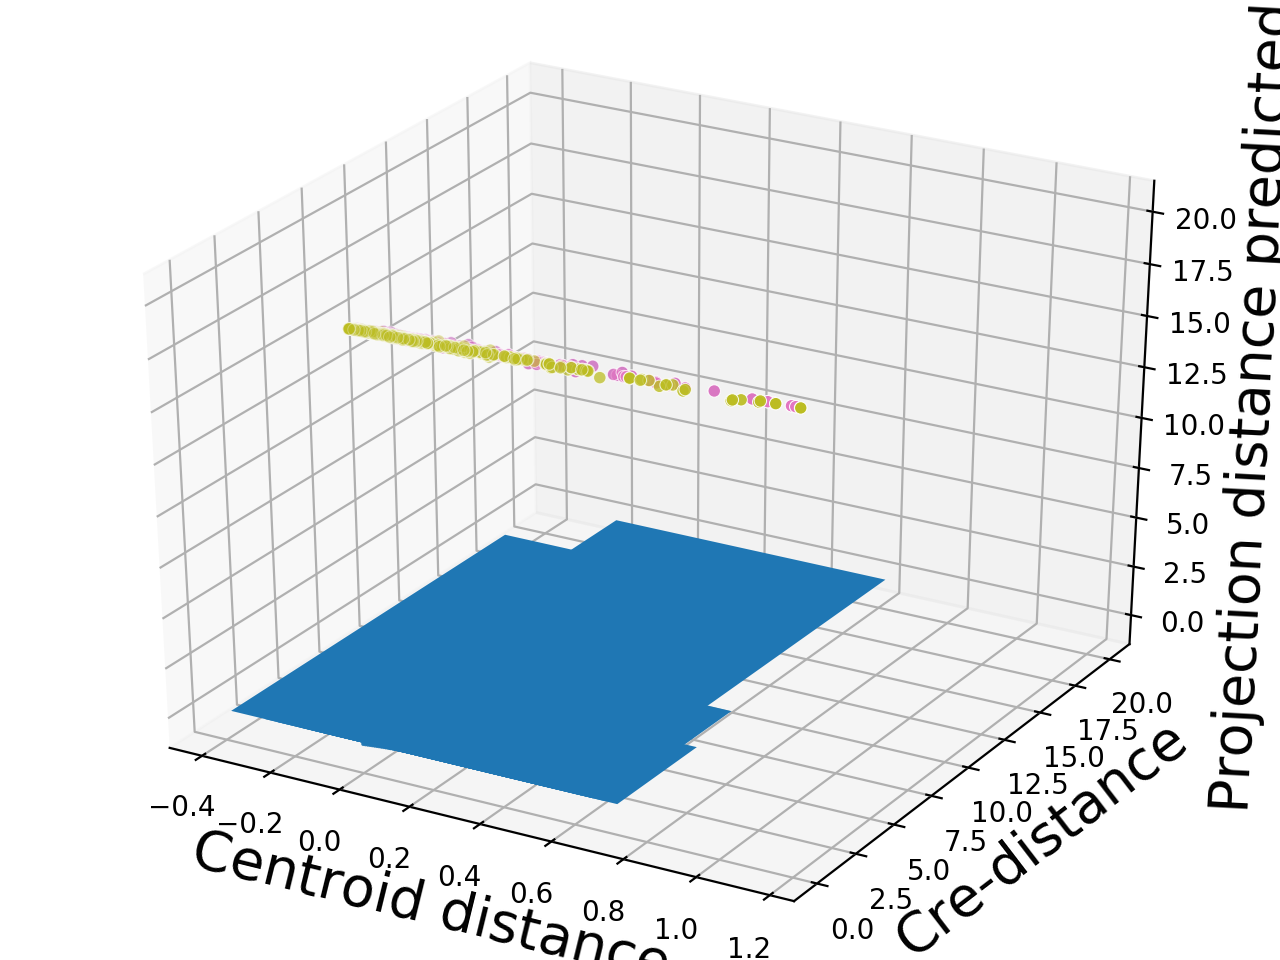

In [244]:
plot_loss_surface(connectivity_data.structure_datas[512].loss_surface_cv_str)

<IPython.core.display.Javascript object>


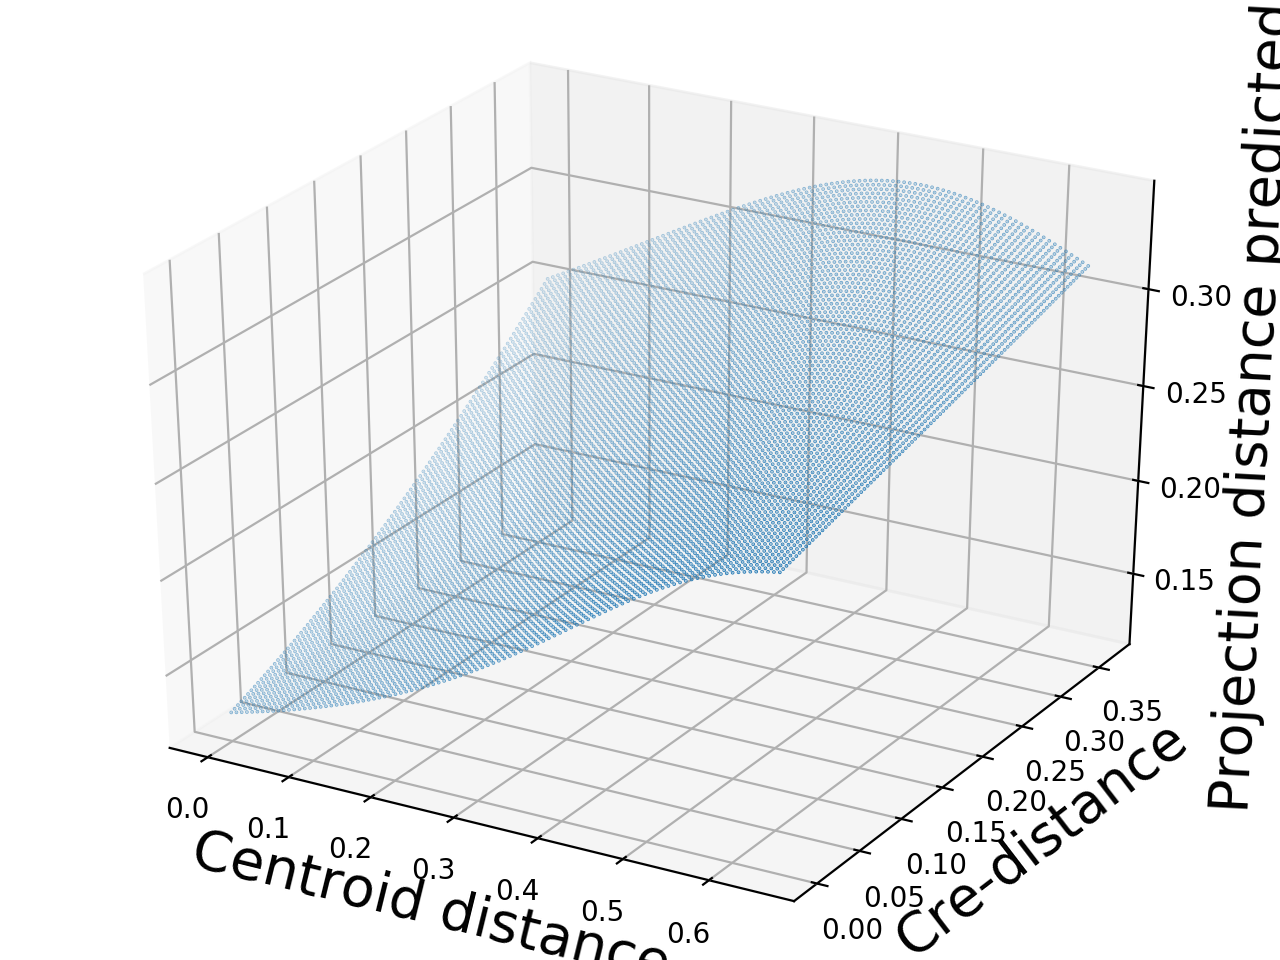

In [238]:
plot_loss_surface(connectivity_data.structure_datas[512].loss_surface_cv_str)

<IPython.core.display.Javascript object>


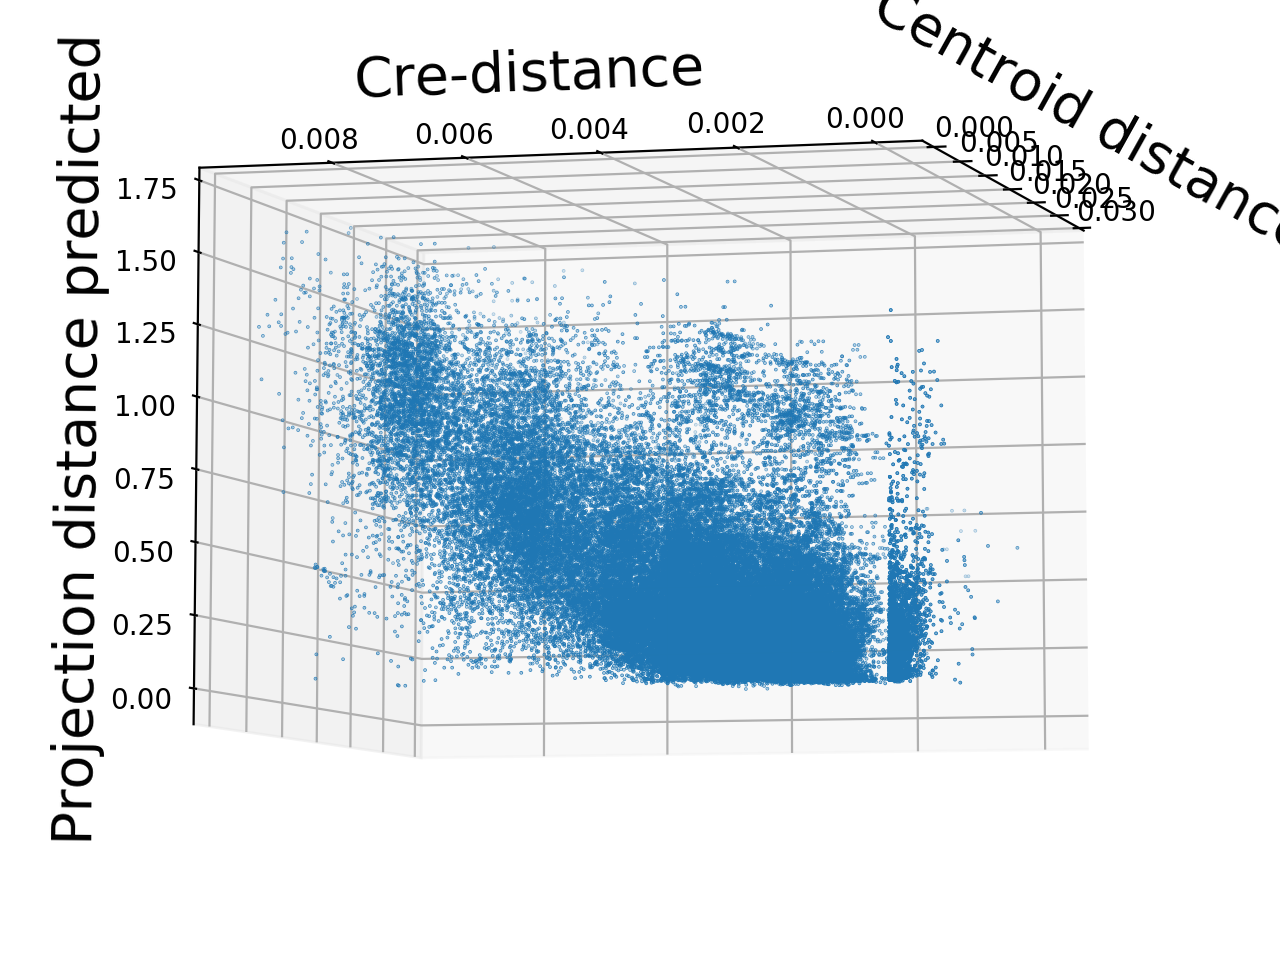

In [213]:
%matplotlib notebook
plot_loss_scatter(connectivity_data.structure_datas[315].loss_surface_cv_str)

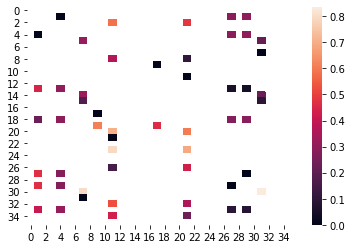

In [201]:
sns.heatmap(connectivity_data.structure_datas[512].loss_surface_cv_str.cre_distances_cv) #credist 0 diag removed

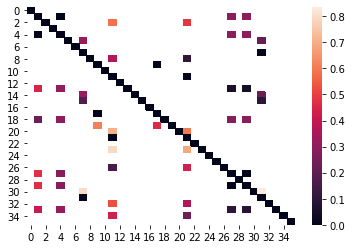

In [191]:
sns.heatmap(connectivity_data.structure_datas[512].loss_surface_cv_str.cre_distances_cv) #credist

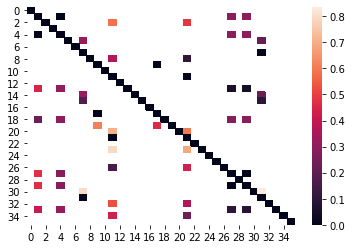

In [181]:
sns.heatmap(connectivity_data.structure_datas[512].loss_surface_cv_str.cre_distances_cv)

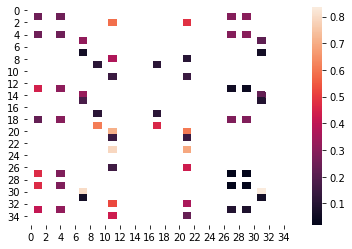

In [171]:
sns.heatmap(connectivity_data.structure_datas[512].loss_surface_cv_str.cre_distances_cv) #this one is still pretty good...

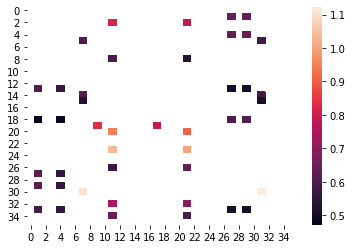

In [154]:
sns.heatmap(connectivity_data.structure_datas[512].loss_surface_cv_str.cre_distances_cv) #n , n -1 not fixed... only fill not same group

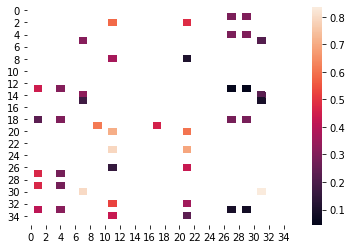

In [144]:
sns.heatmap(connectivity_data.structure_datas[512].loss_surface_cv_str.cre_distances_cv)

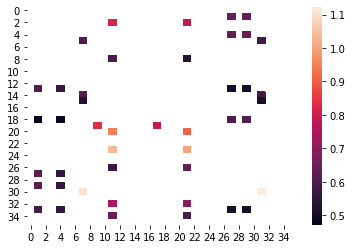

In [137]:
sns.heatmap(connectivity_data.structure_datas[512].loss_surface_cv_str.cre_distances_cv)

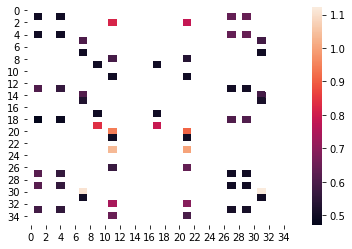

In [125]:
sns.heatmap(connectivity_data.structure_datas[512].loss_surface_cv_str.cre_distances_cv)

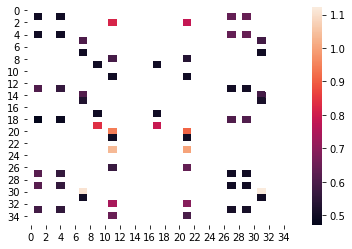

In [129]:
sns.heatmap(connectivity_data.structure_datas[512].loss_surface_cv_str.cre_distances_cv)

In [248]:
class Crossval:
    
    def __init__(self):
        2+2
        
connectivity_data.creleaf2_evalindices = get_eval_indices(connectivity_data.creleaf2_index_matrices)

In [249]:
twostage_leaf_creleaf2 = Crossval()

#gammas = np.asarray([0.1,.5,1,2,10,20,40,100,1000,10000])
gammas = np.asarray([0.001,0.01,0.1,1,10,100,1000,10000])
#gammas = np.asarray([0.1,.5,1,2,10,20,40])
loocvpredictions = {}
reg_proj_norm= {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    loocvpredictions[sid] = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       connectivity_data.structure_datas[sid].smoothed_losses_str,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       #pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.leaf2_index_matrices[sid], 
                                                                                       connectivity_data.leaf2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])
            
    
    
a= [list(range(len(gammas)))]
keys = np.asarray(list(itertools.product(*a)))

twostage_leaf_creleaf2.loocvpredictions = loocvpredictions

twostage_leaf_creleaf2.losses = get_loss(reg_proj_norm, twostage_leaf_creleaf2.loocvpredictions,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
twostage_leaf_creleaf2.bestgamma  = get_best_hyperparameters(twostage_leaf_creleaf2.losses,keys)
twostage_leaf_creleaf2.meanloss = get_loss_best_hyp(twostage_leaf_creleaf2.losses, twostage_leaf_creleaf2.bestgamma)


In [247]:
twostage_leaf_creleaf2.meanloss

array([0.04951634, 0.4966726 , 0.08893662, 0.2432051 , 0.14238011,
       0.12095315, 0.18268591, 0.05988432, 0.23607113, 0.18272094,
       0.05924019, 0.2979301 ])

In [250]:
twostage_leaf_creleaf2.meanloss

array([0.04951634, 0.4966726 , 0.08893662, 0.2432051 , 0.14238011,
       0.12095315, 0.18268591, 0.05988432, 0.23607113, 0.18272094,
       0.05924019, 0.2979301 ])

In [241]:
twostage_leaf_creleaf2.meanloss #n-1 v n fixed,  diagonal removed, leafs not summary, nw good gamma

array([0.04861188, 0.4966726 , 0.08854024, 0.22594589, 0.14337582,
       0.12200105, 0.16841798, 0.05714542, 0.2244447 , 0.14171108,
       0.05942561, 0.3322054 ])

In [233]:
twostage_leaf_creleaf2.meanloss #n-1 v n fixed,  diagonal removed, leafs not summary, nw, tiny gamma

array([0.01404937, 0.4966726 , 0.07905641, 0.17606326, 0.1413341 ,
       0.0859086 , 0.11908564, 0.0369621 , 0.20711828, 0.11561676,
       0.05787192, 0.24494026])

In [228]:
twostage_leaf_creleaf2.meanloss #n-1 v n fixed,  diagonal removed, leafs not summary

array([0.04951634, 0.4966726 , 0.08893662, 0.2432051 , 0.14259214,
       0.12095315, 0.18268591, 0.05988432, 0.23607113, 0.18272094,
       0.05924019, 0.2979301 ])

In [204]:
twostage_leaf_creleaf2.meanloss #n-1 v n fixed,  diagonal removed

array([0.04875316, 0.4966726 , 0.08893464, 0.2432051 , 0.14040992,
       0.11959399, 0.18268591, 0.05988432, 0.23607113, 0.18272094,
       0.05924019, 0.30679831])

In [ ]:
# array([0.04951837, 0.4970684 , 0.10898734, 0.26110819, 0.1509602 ,
#        0.11951267, 0.22278944, 0.07451032, 0.23860635, 0.19459881,
#        0.06375954, 0.57273508]) #nightmare

In [194]:
twostage_leaf_creleaf2.meanloss #n-1 v n fixed,  diagonal

array([0.04716172, 0.4966726 , 0.08891912, 0.24050665, 0.14057327,
       0.11939945, 0.18553791, 0.05923814, 0.2361604 , 0.18604121,
       0.06015571, 0.30777644])

In [184]:
twostage_leaf_creleaf2.meanloss #n-1 v n fixed,  same cre is fixed

array([0.04716172, 0.4966726 , 0.08891912, 0.24050665, 0.14156391,
       0.11939945, 0.18553791, 0.05923814, 0.2361604 , 0.18604121,
       0.06015571, 0.30777644])

In [174]:
twostage_leaf_creleaf2.meanloss #n-1 v n fixed,  same cre is zero not fixed

array([0.05155987, 0.4966726 , 0.08328346, 0.23748675, 0.1305383 ,
       0.1194362 , 0.1511277 , 0.05586835, 0.23290575, 0.15677513,
       0.05464779, 0.29872327])

In [157]:
twostage_leaf_creleaf2.meanloss

array([      nan, 0.4966726,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan])

In [147]:
twostage_leaf_creleaf2.meanloss

array([      nan, 0.4966726,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan])

In [ ]:
#figure out whats going on in the same cre is zero fix, and meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] 

In [128]:
twostage_leaf_creleaf2.meanloss #undo same cre is zero fix, leafs sids fixed, double meani fixed

array([0.04074314, 0.4966726 , 0.07991724, 0.2192497 , 0.12429162,
       0.11696704, 0.15813113, 0.05768053, 0.22860475, 0.14659473,
       0.04867287, 0.29585361])

In [117]:
twostage_leaf_creleaf2.meanloss #same cre-str is zero, leafs sids fixed, double meani fixed

array([      nan, 0.4966726,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan])

In [107]:
twostage_leaf_creleaf2.meanloss #leafs sids fixed, double meani fixed

array([0.04074314, 0.4966726 , 0.07991724, 0.2192497 , 0.12359609,
       0.11696704, 0.15813113, 0.05768053, 0.22860475, 0.14659473,
       0.04867287, 0.29585361])

In [79]:
twostage_leaf_creleaf2.meanloss #leafs sids fixed

array([0.04074314, 0.4966726 , 0.07991724, 0.2192497 , 0.12322508,
       0.11696704, 0.15813113, 0.05768053, 0.22860475, 0.14659473,
       0.04867287, 0.29585361])

In [20]:
twostage_leaf_creleaf2.meanloss 

array([0.04184946, 0.4966726 , 0.08045654, 0.2192497 , 0.12431989,
       0.11991531, 0.15813113, 0.05768053, 0.22860475, 0.14659473,
       0.04867287, 0.29429855])

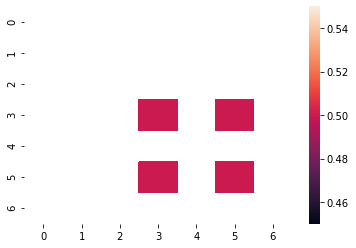

In [80]:
sns.heatmap(connectivity_data.structure_datas[703].loss_surface_cv_str.cre_distances_cv)

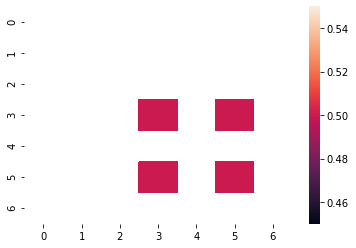

In [22]:
sns.heatmap(connectivity_data.structure_datas[703].loss_surface_cv_str.cre_distances_cv)

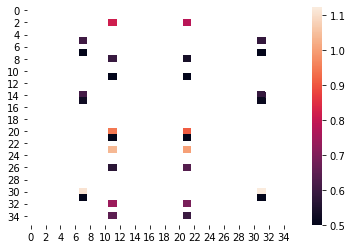

In [23]:
sns.heatmap(connectivity_data.structure_datas[512].loss_surface_cv_str.cre_distances_cv)

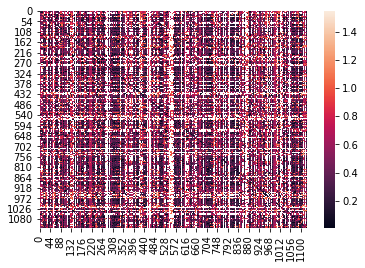

In [24]:
sns.heatmap(connectivity_data.structure_datas[315].loss_surface_cv_str.cre_distances_cv)

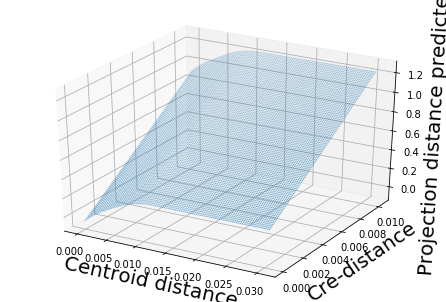

In [25]:
plot_loss_surface(connectivity_data.structure_datas[315].loss_surface_cv_str)

In [ ]:

#def get_cre_distances_cv(proj, means_cast, sids,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        #print(i)
        meani = meani = means_cast[sids[i]][cres[i]]
        ls = np.where(sids == sids[i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        if ncr > 1:
            meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(proj[i].shape[0])
            meanloocvi[:] = np.nan
            
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                if cres[i] != cres[j]:
                    credist[j,i]  = np.linalg.norm(meanloocvi - meanj)
#     nsamp = cres.shape[0]
#     credist = np.empty((nsamp,nsamp))
#     credist[:] = np.nan
#     for i in range(nsamp):
#         #print(i)
#         meani = meani = means_cast[sids[i]][cres[i]]
#         ls = np.where(sids == sids[i])[0]
#         crs = np.where(cres == cres[i])[0]
#         ncr = len(np.intersect1d(ls, crs))
        
#         meanloocvi = meani
#         if ncr > 1:
#             meanloocvi = (meani - (1/ ncr) * proj[i]) * (ncr / (ncr - 1))#(ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
#         else:
#             meanloocvi = np.zeros(proj[i].shape[0])
#             meanloocvi[:] = np.nan
            
#         for j in range(nsamp):
#             meanj = means_cast[sids[j]][cres[j]]
#             if sids[j] == sids[i]:
#                 if cres[i] != cres[j]:
#                     credist[j,i]  = np.linalg.norm(meanloocvi - meanj)
#                     #print('here',i,j,credist[j,i])
#                 else: 
#                     credist[j,i] = 0.
#                     #print('he',i,j,credist[j,i])
                    
#    return(credist)

In [26]:

sids = connectivity_data.summary_structures[703]
cres=  connectivity_data.creline[703]
projections = connectivity_data.structure_datas[703].reg_proj_norm
#print(cres[np.where(sids == 91)[0]])

In [97]:
    cre_means = {}
    cre_types = np.unique(cres)
    sid_types = np.unique(sids)
    for i in range(len(sid_types)):
        cre_means[sid_types[i]] = {}
        sid_inds = np.where(sids == sid_types[i])[0]
        for j in range(len(cre_types)): 
            cre_inds = np.where(cres == cre_types[j])[0]
            cre_means[sid_types[i]][cre_types[j]] = np.mean(projections[np.intersect1d(sid_inds, cre_inds)], axis = 0 )
    proj = projections
    means_cast = cre_means
    means_cast = cre_means
    #def get_cre_distances_cv(proj, means_cast, sids,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        #print(i)
        meani = means_cast[sids[i]][cres[i]]
        ls = np.where(sids == sids[i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        if ncr > 1:
            meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(proj[i].shape[0])
            meanloocvi[:] = np.nan
            
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                if cres[i] != cres[j]:
                    credist[j,i]  = np.linalg.norm(meanloocvi - meanj)
                    print('asdf', i , j , meanloocvi.max(), meanj.max(), ncr)

asdf 0 6 nan 0.505946476113443 1
asdf 2 4 nan 0.876426808494385 1
asdf 4 2 nan 0.9596430993020553 1
asdf 6 0 nan 0.7558552591017265 1


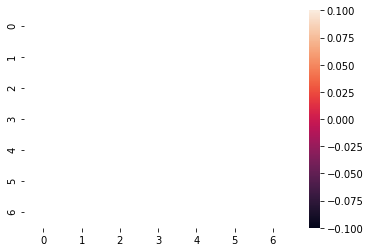

In [98]:
sns.heatmap(credist)

In [89]:
    cre_means = {}
    cre_types = np.unique(cres)
    sid_types = np.unique(sids)
    for i in range(len(sid_types)):
        cre_means[sid_types[i]] = {}
        sid_inds = np.where(sids == sid_types[i])[0]
        for j in range(len(cre_types)): 
            cre_inds = np.where(cres == cre_types[j])[0]
            cre_means[sid_types[i]][cre_types[j]] = np.mean(projections[np.intersect1d(sid_inds, cre_inds)], axis = 0 )
    proj = projections
    means_cast = cre_means

In [90]:
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        #print(i)
        meani = means_cast[sids[i]][cres[i]]
        ls = np.where(sids == sids[i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        print(ncr,'ncr')
        if ncr > 1:
            meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(proj[i].shape[0])
            meanloocvi[:] = np.nan
            
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                if cres[i] != cres[j]:
                    credist[j,i]  = np.linalg.norm(meanloocvi - meanj)
                else:
                    print(i,j)

1 ncr
0 0
1 ncr
1 1
1 ncr
2 2
2 ncr
3 3
3 5
1 ncr
4 4
2 ncr
5 3
5 5
1 ncr
6 6


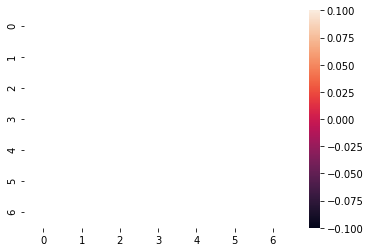

In [91]:
sns.heatmap(credist)

In [31]:

    #def get_cre_distances_cv(proj, means_cast, sids,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        #print(i)
        meani = meani = means_cast[sids[i]][cres[i]]
        ls = np.where(leafs[sid] == leafs[sid][i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        if ncr > 1:
            meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(proj[i].shape[0])
            meanloocvi[:] = np.nan
            
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                credist[j,i]  = np.linalg.norm(meanloocvi - meanj)

    #return(credist)


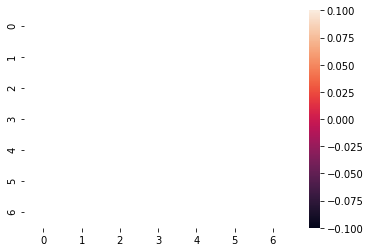

In [32]:
sns.heatmap(credist)

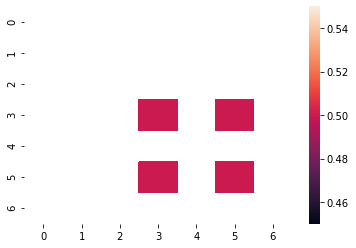

In [34]:
sns.heatmap(connectivity_data.structure_datas[703].loss_surface_cv_str.cre_distances_cv)

In [84]:
    projections = connectivity_data.structure_datas[703].reg_proj_norm
    sids = connectivity_data.summary_structures[703]
    cres=  connectivity_data.creline[703]
    #def get_means(projections, cres, sids):
    cre_means = {}
    cre_types = np.unique(cres)
    sid_types = np.unique(sids)
    for i in range(len(sid_types)):
        cre_means[sid_types[i]] = {}
        sid_inds = np.where(sids == sid_types[i])[0]
        for j in range(len(cre_types)): 
            cre_inds = np.where(cres == cre_types[j])[0]
            cre_means[sid_types[i]][cre_types[j]] = np.mean(projections[np.intersect1d(sid_inds, cre_inds)], axis = 0 )
    #return(cre_means)
    means_cast = cre_means
    #def get_cre_distances_cv(proj, means_cast, sids,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        #print(i)
        meani = means_cast[sids[i]][cres[i]]
        ls = np.where(sids == sids[i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        if ncr > 1:
            meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(proj[i].shape[0])
            meanloocvi[:] = np.nan
            
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                
                credist[j,i]  = np.linalg.norm(meanloocvi - meanj)
                print('asdf', i , j , meanloocvi.max(), meanj.max(), ncr)

asdf 0 0 nan 0.7558552591017265 1
asdf 0 6 nan 0.505946476113443 1
asdf 1 1 nan 0.5162507425389311 1
asdf 2 2 nan 0.9596430993020553 1
asdf 2 4 nan 0.876426808494385 1
asdf 3 3 0.8011490375116728 0.49491216508630376 2
asdf 3 5 0.8011490375116728 0.49491216508630376 2
asdf 4 2 nan 0.9596430993020553 1
asdf 4 4 nan 0.876426808494385 1
asdf 5 3 0.6835874577472385 0.49491216508630376 2
asdf 5 5 0.6835874577472385 0.49491216508630376 2
asdf 6 0 nan 0.7558552591017265 1
asdf 6 6 nan 0.505946476113443 1


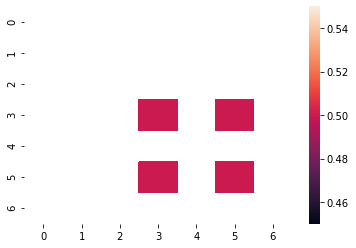

In [85]:
sns.heatmap(credist)

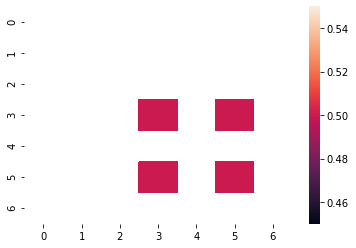

In [70]:
sns.heatmap(credist)

In [47]:
cres

array(['Cux2-IRES-Cre', 'Rbp4-Cre_KL100', 'Dlg3-Cre_KG118',
       'Gnb4-IRES2-Cre', 'C57BL/6J', 'Gnb4-IRES2-Cre',
       'Ppp1r17-Cre_NL146'], dtype=object)

In [48]:
sids

array([131, 780, 295, 583, 295, 583, 131], dtype=object)

In [50]:
means_cast[295]['Gnb4-IRES2-Cre']

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [52]:
sid_types, cre_types

(array([131, 295, 583, 780], dtype=object),
 array(['C57BL/6J', 'Cux2-IRES-Cre', 'Dlg3-Cre_KG118', 'Gnb4-IRES2-Cre',
        'Ppp1r17-Cre_NL146', 'Rbp4-Cre_KL100'], dtype=object))

In [56]:
sid_inds

array([2, 4])

In [57]:
cre_inds

array([3, 5])

In [59]:
i = 2
j = 3
#for i in range(len(sid_types)):
cre_means[sid_types[i]] = {}
sid_inds = np.where(sids == sid_types[i])[0]
#    for j in range(len(cre_types)): 
cre_inds = np.where(cres == cre_types[j])[0]
cre_means[sid_types[i]][cre_types[j]] = np.mean(projections[np.intersect1d(sid_inds, cre_inds)], axis = 0 )


In [60]:
np.intersect1d(sid_inds, cre_inds)

array([3, 5])

In [63]:
i = 2
j = 3
cre_means[sid_types[i]][cre_types[j]]

array([1.30536151e-04, 9.52521947e-07, 0.00000000e+00, 1.10713336e-05,
       2.06208323e-05, 6.29674623e-04, 1.64564225e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.51098108e-05, 1.48069930e-01,
       3.27890426e-02, 8.43890597e-02, 1.34254326e-02, 1.03433360e-04,
       2.29141234e-05, 0.00000000e+00, 0.00000000e+00, 2.09721902e-06,
       0.00000000e+00, 2.50502003e-04, 0.00000000e+00, 8.43195286e-05,
       7.34148127e-06, 7.28621361e-05, 1.66569083e-01, 0.00000000e+00,
       2.87635921e-01, 0.00000000e+00, 1.75882854e-05, 7.00926837e-02,
       1.05904344e-04, 2.06387755e-05, 3.95483136e-05, 2.33385103e-02,
       7.81724248e-07, 0.00000000e+00, 0.00000000e+00, 6.75925292e-07,
       2.16634243e-07, 3.91800245e-04, 3.88905479e-04, 1.24131669e-07,
       4.33985871e-02, 3.22656557e-06, 0.00000000e+00, 4.01037313e-08,
       1.00499410e-04, 0.00000000e+00, 2.41906629e-08, 5.98653443e-05,
       4.26471853e-02, 5.42290542e-07, 1.86215157e-06, 6.96104699e-04,
      

In [214]:
#twostage_leaf_creleaf2 = Crossval()

pds = {}
for sid in major_structure_ids:
    pds[sid] = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2
    
#gammas = np.asarray([0.1,.5,1,2,10,20,40,100,1000,10000])
gammas = np.asarray([0.001,0.01,0.1,1,10,100,1000,10000])
#gammas = np.asarray([0.1,.5,1,2,10,20,40])
loocvpredictions = {}
reg_proj_norm= {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    print(sid)
    #print(connectivity_data.structure_datas[sid].reg_proj_norm.shape)
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    #pds = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2
    print('here')
    loocvpredictions[sid] = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm[:,:], 
                                                                                       #connectivity_data.structure_datas[sid].smoothed_losses_str,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       pds[sid],                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.creleaf2_index_matrices[sid], 
                                                                                       connectivity_data.creleaf2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])

512
here
703
here
1089
here


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


1097
here
315
here
313
here
354
here
698
here
771
here
803
here
477
here
549
here


In [215]:

reg_proj_norm= {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    
a= [list(range(len(gammas)))]
keys = np.asarray(list(itertools.product(*a)))
nw_creleaf_creleaf2 = Crossval()
nw_creleaf_creleaf2.loocvpredictions = loocvpredictions
nw_creleaf_creleaf2.losses = get_loss(reg_proj_norm, nw_creleaf_creleaf2.loocvpredictions,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
nw_creleaf_creleaf2.bestgamma  = get_best_hyperparameters(nw_creleaf_creleaf2.losses,keys)
nw_creleaf_creleaf2.meanloss = get_loss_best_hyp(nw_creleaf_creleaf2.losses, nw_creleaf_creleaf2.bestgamma)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

In [251]:
error_nw = (nw_creleaf_creleaf2.loocvpredictions[315][nw_creleaf_creleaf2.bestgamma[4][0]] - reg_proj_norm[315])**2

error_2s = (twostage_leaf_creleaf2.loocvpredictions[315][twostage_leaf_creleaf2.bestgamma[4][0]] - reg_proj_norm[315])**2

In [261]:
errors_nwsum = np.nansum(error_nw, axis = 1)
errors_2ssum = np.nansum(error_2s, axis = 1)

In [280]:
import matplotlib.pyplot as plt

In [292]:
a = np.asarray(errors_nwsum, dtype = float)
b = np.asarray(errors_2ssum, dtype = float)

In [303]:
(a - b).sum()

8.89773618357306

In [304]:
a_wt = a[np.where(connectivity_data.creline[315] == 'C57BL/6J')[0]]
b_wt = b[np.where(connectivity_data.creline[315] == 'C57BL/6J')[0]]

In [314]:
(a_wt - b_wt)[np.argmin(a_wt - b_wt)]

-0.10356096472627341

In [388]:
np.argmin(a_wt - b_wt) #the 2s error is really bad for this one....

56

In [309]:
np.where(connectivity_data.creline[315] == 'C57BL/6J')[0][56]

573

In [312]:
ia_map[connectivity_data.leafs[315][573]]

'VISp4'

(array([17.,  0.,  0.,  6.,  3.,  0., 20.,  5.,  8.,  5.]),
 array([0.        , 0.0334711 , 0.0669422 , 0.1004133 , 0.1338844 ,
        0.1673555 , 0.2008266 , 0.23429771, 0.26776881, 0.30123991,
        0.33471101]),
 <a list of 10 Patch objects>)

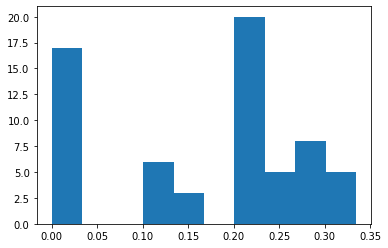

In [317]:
%matplotlib inline
plt.hist(connectivity_data.structure_datas[315].loss_surface_cv_str.cre_distances_cv[573])

In [322]:
c = np.linalg.norm(connectivity_data.structure_datas[315].centroids - connectivity_data.structure_datas[315].centroids[573] , axis = 1)

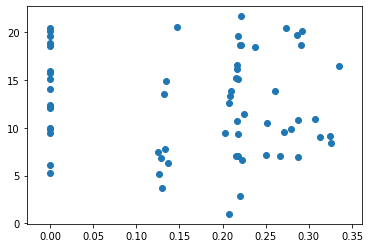

In [330]:
plt.scatter(connectivity_data.structure_datas[315].loss_surface_cv_str.cre_distances_cv[573], c)

(-0.001, 0.005)

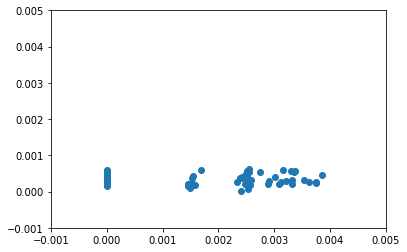

In [337]:
plt.scatter(connectivity_data.structure_datas[315].loss_surface_cv_str.cre_distances_cv[573]/ 
            connectivity_data.structure_datas[315].loss_surface_cv_str.norms[1],
             c/  connectivity_data.structure_datas[315].loss_surface_cv_str.norms[0])
plt.xlim(-.001,.005)
plt.ylim(-.001,.005)

In [339]:
gammas[4],gammas[2]

10.0

In [340]:
nw_creleaf_creleaf2.bestgamma[4]
#twostage_leaf_creleaf2.bestgamma[4]

array([2])

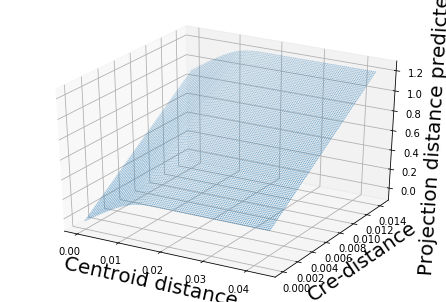

In [351]:
plot_loss_surface(connectivity_data.structure_datas[315].loss_surface_cv_str)

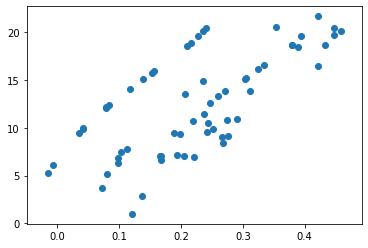

In [390]:
plt.scatter(connectivity_data.structure_datas[315].smoothed_losses_str[573],c)

In [430]:
truth = np.linalg.norm(connectivity_data.structure_datas[315].reg_proj_norm[indos] - connectivity_data.structure_datas[315].reg_proj_norm[573], axis = 1)

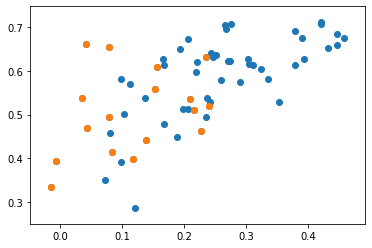

In [432]:
plt.scatter(connectivity_data.structure_datas[315].smoothed_losses_str[573,:][indos], truth)
nnn = np.where(connectivity_data.creline[315][indos] == 'C57BL/6J')[0]
plt.scatter(connectivity_data.structure_datas[315].smoothed_losses_str[573,:][indos][nnn], truth[nnn])

In [424]:
connectivity_data.structure_datas[315].smoothed_losses_str[573,:][indos].argsort()

array([29, 30, 23, 45, 54, 17, 55,  4, 14, 10,  8, 44, 33, 51, 58,  1, 32,
       39, 60, 19, 57, 15, 34, 62, 49,  5, 22, 47, 63, 50, 21, 52, 61,  2,
       24, 27, 38, 26, 28, 31, 53, 25, 37,  0, 20, 59, 41, 43,  9, 56, 46,
       42, 16,  6, 11,  3, 40,  7, 36, 13, 35, 12, 48, 18])

In [485]:
wt_str = np.setdiff1d(wt_str, 573)

In [408]:
truth = np.linalg.norm(connectivity_data.structure_datas[315].reg_proj_norm[wt_str] - connectivity_data.structure_datas[315].reg_proj_norm[573], axis = 1)

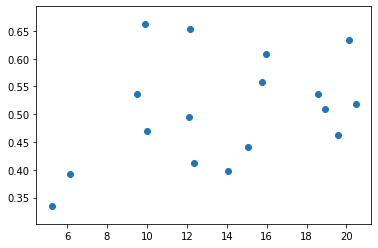

In [409]:
plt.scatter(c[wt_str], truth)

In [524]:
ws1 = np.exp(- (c[wt_str] - np.min(c[wt_str]))**2  * gammas[2])
ws1 = np.asarray(ws1, dtype = np.float32)
ws1[np.isnan(ws1)] = 0.
ws1 = ws1 / ws1.sum()
r1 = ws1  @ connectivity_data.structure_datas[315].reg_proj_norm[wt_str]
ws2 =  np.exp(- (connectivity_data.structure_datas[315].smoothed_losses_str[573,:][indos] - 
                 np.min(connectivity_data.structure_datas[315].smoothed_losses_str[573,:][indos]) ) * gammas[4])
ws2 = ws2 / ws2.sum()

In [525]:

r2  = ws2 @ connectivity_data.structure_datas[315].reg_proj_norm[indos]

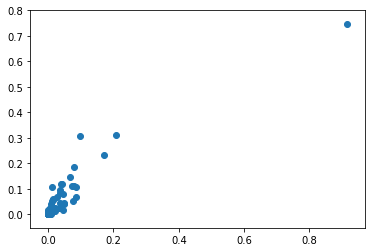

In [526]:
plt.scatter(r1, connectivity_data.structure_datas[315].reg_proj_norm[573])

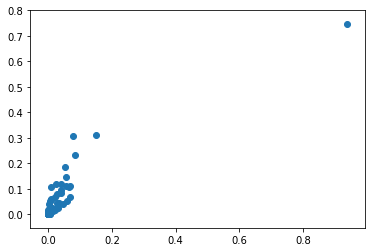

In [527]:
plt.scatter(r2, connectivity_data.structure_datas[315].reg_proj_norm[573])

In [505]:
print(np.linalg.norm(r2 - connectivity_data.structure_datas[315].reg_proj_norm[573]))
np.linalg.norm(r1 - connectivity_data.structure_datas[315].reg_proj_norm[573])

0.46478896626699695


0.38593828343322406

In [510]:
print(np.linalg.norm(r2 - connectivity_data.structure_datas[315].reg_proj_norm[573]))
np.linalg.norm(nw_creleaf_creleaf2.loocvpredictions[315][2][573] - connectivity_data.structure_datas[315].reg_proj_norm[573])

0.46478896626699695


0.34752293594594424

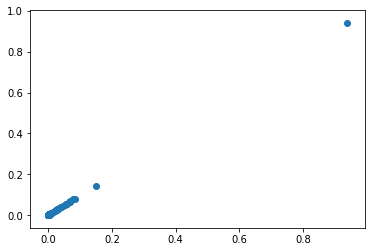

In [506]:
plt.scatter(r2, twostage_leaf_creleaf2.loocvpredictions[315][4][573])

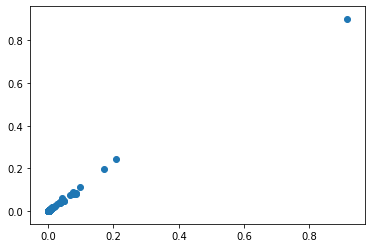

In [528]:
plt.scatter(r1, nw_creleaf_creleaf2.loocvpredictions[315][2][573])

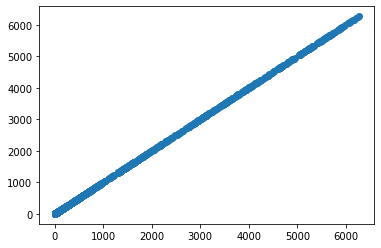

In [512]:
plt.scatter(pds[315][573], (c - np.min(c))**2)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


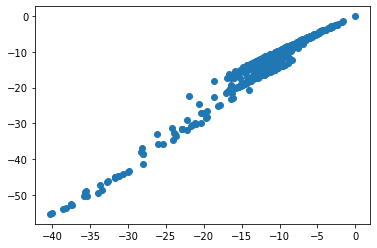

In [529]:
plt.scatter(np.log(r1), np.log(nw_creleaf_creleaf2.loocvpredictions[315][2][573]))

In [513]:
ws1 = np.exp(- (c[wt_str] - np.min(c[wt_str]))**2  * gammas[2])
ws1 = np.asarray(ws1, dtype = np.float32)
ws1[np.isnan(ws1)] = 0.
ws1 = ws1 / ws1.sum()
r1 = ws1  @ connectivity_data.structure_datas[315].reg_proj_norm[wt_str]

(1128,)

In [530]:
    sid = 315
    #def get_nw_predictions(projections, dists, gamma):
    #distances = (c - np.min(c))**2[wt_str]
    projections = connectivity_data.structure_datas[sid].reg_proj_norm[wt_str]
    gamma = gammas[2]
#     projections = np.asarray(projections, dtype=np.float32)
#     neval = dists.shape[1]
#     #nexp = centroids.shape[0]
#     predictions = np.zeros((neval, projections.shape[1]))
#     predictions[:] = np.nan
    
    #print(model_index_val.shape, eval_index_val.shape)
    #weights = np.exp(- dists / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
    #for i in range(neval):
    
    #using min[wt_str] made the difference
    dists_i = ((c[wt_str] - np.min(c[wt_str]))**2)#dists[:,i] - np.min(dists[:,i])
    #dists_i = dists[i,:] - np.min(dists[i,:])
    weights_i = np.exp(- dists_i * gamma)
    weights_i = np.asarray(weights_i, dtype=np.float32)
    weights_i[np.isnan(weights_i)] = 0.
    weights_i = weights_i / np.sum(weights_i)
    predictions = np.dot(weights_i, projections)

    #return(predictions) 

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


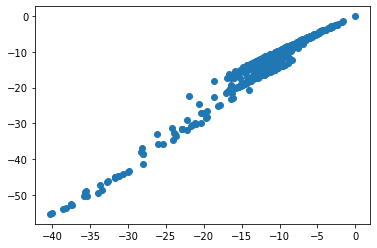

In [531]:
plt.scatter(np.log(predictions), np.log(nw_creleaf_creleaf2.loocvpredictions[315][2][573]))

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


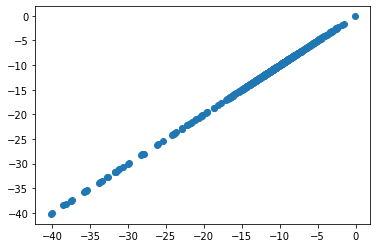

In [532]:
plt.scatter(np.log(predictions), np.log(r1))

In [543]:
r1.shape

(577,)

In [535]:
model_indices = wt_str
dists_i = (c[wt_str] - np.min(c[wt_str]))**2

In [539]:

    #def get_nwloocv_predictions_singlemodel_dists(projections, dists, gamma, model_indices, eval_indices):
    #eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = wt_str
    #print('e', eval_index_val, 'm', model_index_val)

    projections = np.asarray(projections, dtype=np.float32)

    nmod_ind = len(model_index_val)
    #neval = len(eval_index_val)
    # nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    predictions[:] = np.nan
    #if len(model_index_val) > 0 and len(eval_index_val) > 0:
        # weights = np.exp(-dists[model_index_val][:, eval_index_val] / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
        #for i in range(neval):
    matchindex = np.where(model_index_val == 573)[0]
    otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)
    # this order of operations is the fastest I found
    #dists_i = dists[model_index_val][:, 573] - np.min(dists[model_index_val[otherindices]][:, 573])
    weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
    # print(np.nansum(weights[:,i][otherindices]))
    weights_i[matchindex] = 0
    weights_i = np.asarray(weights_i, dtype=np.float32)
    weights_i = weights_i / np.sum(weights_i)
    # weights_i[np.isnan(weights_i)] = 0.
    pred = np.dot(weights_i, projections)
    #predictions[eval_index_val[i]] = pred

    #return (predictions)

In [542]:
predictions.shape

(17, 577)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


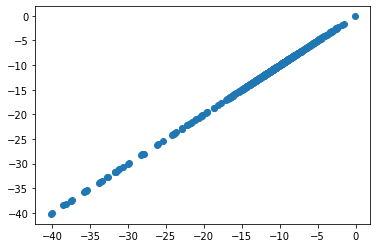

In [544]:
plt.scatter(np.log(r1), np.log(pred))

In [509]:
twostage_leaf_creleaf2.bestgamma[4]

array([4])

In [446]:
twostage_leaf_creleaf2.loocvpredictions[315].shape

(8, 1128, 577)

In [358]:
indos = np.where(~np.isnan(connectivity_data.structure_datas[315].smoothed_losses_str[573]))[0]

In [359]:
c[indos][c[indos].argsort()]

array([ 1.00448529,  2.90894955,  3.68819047,  5.14519427,  5.23644048,
        6.1566662 ,  6.33212174,  6.58776125,  6.87879033,  6.97727398,
        7.00399073,  7.04747361,  7.07211857,  7.14219696,  7.46674201,
        7.78897666,  8.45598466,  9.02975856,  9.14052235,  9.33155254,
        9.46850844,  9.51189522,  9.54115987,  9.85520373,  9.9016673 ,
        9.98525051, 10.55620664, 10.71912434, 10.81485076, 10.90774628,
       11.47825782, 12.11699658, 12.14738904, 12.35831139, 12.62729144,
       13.29998507, 13.57275907, 13.83050639, 13.90608701, 14.08354785,
       14.88569531, 15.06497879, 15.08589856, 15.21950403, 15.76756552,
       15.95959315, 16.11677998, 16.48605781, 16.6231744 , 18.51264998,
       18.58064331, 18.64048162, 18.64727664, 18.70601035, 18.91528982,
       19.57540851, 19.57733883, 19.69678302, 20.12263517, 20.18213938,
       20.41117281, 20.47187639, 20.54559204, 21.67037372])

In [364]:
np.linalg.norm(connectivity_data.structure_datas[315].centroids[573] - connectivity_data.structure_datas[315].centroids[23])

1.00448529053704

In [366]:
connectivity_data.leafs[315][[573,23]],connectivity_data.creline[315][[573,23]]

(array([721, 721]), array(['C57BL/6J', 'Scnn1a-Tg3-Cre'], dtype=object))

In [369]:
Scnn1a = np.where(connectivity_data.creline[315] == 'Scnn1a-Tg3-Cre')[0]
wt = np.where(connectivity_data.creline[315] == 'C57BL/6J')[0]

In [371]:
ls = np.where(connectivity_data.leafs[315] == 721)[0]

In [378]:
np.linalg.norm(connectivity_data.structure_datas[315].reg_proj_norm[573] - 
connectivity_data.structure_datas[315].reg_proj_norm[23] )

0.28576088839034597

In [379]:
Scnn1a_wtr = np.intersect1d(ls,Scnn1a)

In [477]:
wt_str = np.intersect1d(ls,wt)

In [385]:
Scnn1a_mean = np.mean(connectivity_data.structure_datas[315].reg_proj_norm[Scnn1a_wtr], axis = 0)

In [386]:
[np.linalg.norm(connectivity_data.structure_datas[315].reg_proj_norm[573] - 
connectivity_data.structure_datas[315].reg_proj_norm[Scnn1a_wtr[i]] ) for i in range(len(Scnn1a_wtr))]

[0.28576088839034597,
 0.6219221719988886,
 0.5794576377394307,
 0.5374246100947392,
 0.6326987838122609,
 0.4480823799925769]

In [387]:
[np.linalg.norm(connectivity_data.structure_datas[315].reg_proj_norm[573] - 
connectivity_data.structure_datas[315].reg_proj_norm[wt_str[i]] ) for i in range(len(wt_str))]

[0.6539914609324374,
 0.4129452780621227,
 0.6082169792505943,
 0.5371351911783837,
 0.632899382947287,
 0.3342958614623995,
 0.39284745421080686,
 0.0,
 0.5184435043822309,
 0.4413918451602543,
 0.6626078299335223,
 0.5100011966072462,
 0.4694148784512878,
 0.4943937215960685,
 0.3971481285985351,
 0.5577381477845799,
 0.46195916600029197,
 0.5363843534199461]

In [362]:
indos[1]

23

In [360]:
c[indos].argsort()

array([ 1, 32, 17, 14, 29, 30, 44, 15,  8, 52, 57, 34, 22, 49, 33, 51,  0,
       37, 41,  5, 62, 23, 26, 53, 45, 54, 28, 21, 59, 43, 27, 55,  4, 10,
       31, 25, 47, 20, 46, 58,  2,  9, 39, 56, 60, 19, 42, 13, 16, 40, 63,
       11, 35,  3, 50,  7, 61, 12, 24, 18, 48, 38,  6, 36])

In [344]:
tz = np.asarray([connectivity_data.structure_datas[315].loss_surface_cv_str.cre_distances_cv[573]/ 
            connectivity_data.structure_datas[315].loss_surface_cv_str.norms[1],
             c/  connectivity_data.structure_datas[315].loss_surface_cv_str.norms[0]])

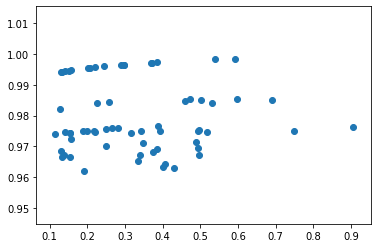

In [347]:
plt.scatter(np.exp(- c * gammas[2]), np.exp(- gammas[4] * np.linalg.norm(tz, axis = 0)))

(array([ 92., 198., 146., 157.,  78.,  91.,  81., 113.,  85.,  87.]),
 array([ 0.        ,  7.91637255, 15.8327451 , 23.74911765, 31.6654902 ,
        39.58186275, 47.4982353 , 55.41460785, 63.3309804 , 71.24735295,
        79.1637255 ]),
 <a list of 10 Patch objects>)

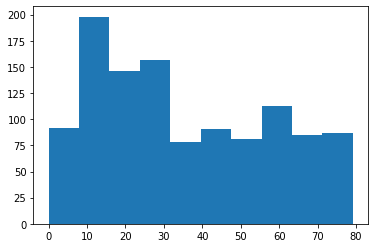

In [323]:
plt.hist(c)

In [295]:
a[:10]

array([0.        , 0.00511805, 0.03468514, 0.        , 0.57536789,
       0.25616867, 0.        , 0.13004947, 0.        , 0.26536498])

In [273]:
improve = np.nansum(error_nw - error_2s, axis = 1)

In [274]:
improve.sum() / 732

0.012155377299963199

In [260]:
improve[np.where(connectivity_data.creline[315] == 'C57BL/6J')[0]].sum() / 122

0.0048798304416228415

In [256]:
nw_creleaf_creleaf2.loocvpredictions[315].shape

(8, 1128, 577)

In [257]:
len(connectivity_data.creleaf2_evalindices[315])

732

In [259]:
len(np.where(connectivity_data.creline[315] == 'C57BL/6J')[0])

122